In [1]:
import numpy as np
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib

import utilities
from simple_hamiltonians import Fluxonium, Kite_Transmon_Full
from model_hamiltonians import (UncoupledOscillators,
                                FluxoniumCoupledToOscillators, Kite_transmon_CoupledToResonator)

In [46]:
# Initial guess for the qubit parameters.
params = {'E_C': 1.64/50, # The charging energy of the shunting cap
        'E_L': 2.14, # The inductive energy of the branch inductance
        'E_J': 21.43, # The Josephson energy of a JJ
        'E_CJ': 7.14, # The charging energy of a JJ
        'eps_l' : 0., # Asymmetry in inductive energy between L of each branch
        'eps_j' : 0., # Asymmetry in Josephson energy between JJ of each branch
        'eps_c' : 0., # Asymmetry in charging energy between JJ of each branch
        'phi_ext': 0.5, # External flux threading the loop
        'n_g' : 0., # Offset charge in the island
        'num_qbt_0': 30,
        'num_qbt_1': 30,
        'num_qbt_2': 25,
        'num_osc': 40, # number of modes of the Kite in the eigenbasis
        'f_r': 4.7, # resonator frequency
        'g_r_J': .200, # Coupling to resonator
        'num_res': 20,
        'num_tot': 20, # number of modes of the coupled system
        'error_type': 'relative_error',
        'data_set': 'data3'
        }

In [33]:
import qutip as qt

def spec_fluxonium(Nmax, EJ, EC, EL, phiext_vec, ifeigvecs=False):
    phizpf = (2*EC/EL)**(1/4)
    nzpf = 0.5*(EL/2/EC)**(1/4)
    Omega = np.sqrt(8*EL*EC)

    a = qt.destroy(Nmax)
    adag = a.dag()
    phi = phizpf*(a + adag)
    N = nzpf*(a-adag)/1j
    cosphi = 0.5*((1j*phi).expm()+(-1j*phi).expm())
    sinphi = 0.5*((1j*phi).expm()-(-1j*phi).expm())/1j

    eig_vals_vec = []
    matrix_elements_vec = []

    for phiext in phiext_vec:
        H = Omega*(adag*a+0.5)-EJ*(np.cos(phiext)*cosphi-np.sin(phiext)*sinphi-1)

        matrix_elements = []
        if ifeigvecs:
            eig_vals, eig_vecs = H.eigenstates()        
            for op in [N, phi]:
                matrix_elements.append(np.abs(eig_vecs[0].dag()*op*eig_vecs[1])**2)
            
        else:
            eig_vals = H.eigenenergies()
            for op in [N, phi]:
                matrix_elements.append(0)
                
        matrix_elements = np.array(matrix_elements)

        eig_vals_vec.append(eig_vals)
        matrix_elements_vec.append(matrix_elements)

    eig_vals_vec = np.array(eig_vals_vec)
    matrix_elements_vec = np.array(matrix_elements_vec)
    
    return eig_vals_vec, matrix_elements_vec


def getEJ2(EJ, EC, EL, Nmax=100, phiext_vec=None, ifplot=False):
    if phiext_vec is None:
        phimin, phimax, dphi = -2*np.pi, 2*np.pi, 0.1
        Npts = int((phimax-phimin)/dphi)+1
        phiext_vec = np.linspace(phimin, phimax, Npts)
    eigvals_vec, _ = spec_fluxonium(Nmax, EJ, EC, EL, phiext_vec, ifeigvecs=False)
    Ufluxo = eigvals_vec[:,0]-np.mean(eigvals_vec[:,0])
    UfluxoFourrier = np.fft.fft(Ufluxo)
    frequency = np.fft.fftfreq(Npts, dphi)
    pos_freqs = frequency[0:int(Npts/2)]
    pos_spec = UfluxoFourrier[0:int(Npts/2)]
    idcs = np.argsort(np.abs(pos_spec))
    idcs = idcs[::-1]
    max_vals = pos_spec[idcs]
    max_freqs = pos_freqs[idcs]
    nHarmonics = 5
    def Ufluxo_harm(_phiext):
        UfluxoFourrierInv = np.zeros(Npts)
        for jj in np.arange(nHarmonics):
            UfluxoFourrierInv = UfluxoFourrierInv + max_vals[jj]*2*np.cos(2*np.pi*max_freqs[jj]*(_phiext))
        UfluxoFourrierInv = UfluxoFourrierInv/Npts
        return UfluxoFourrierInv
    U0 = Ufluxo_harm(phiext_vec)
    Upi = Ufluxo_harm(phiext_vec+np.pi)
    Usum = U0 + Upi
    EJ2 = (np.max(Usum)-np.min(Usum))/2
    #print('EJ2 = %s GHz' % EJ2)
    EJ2 = np.real(max_vals[1]*2*2/Npts)
    EJ4 = np.real(max_vals[3]*2*2/Npts)
    EJ6 = np.real(max_vals[5]*2*2/Npts)
    offset = 0.5*(np.sqrt(8*EC*EJ)-EC/2)
    EJeff = EJ-0*EL*np.pi**2/4
    Gamma = (4/np.sqrt(np.pi))*(8*EJeff**3*EC)**(1/4)*np.exp(-np.sqrt(8*EJeff/EC))
    EJ2_th = (1/8)*EL*np.pi**2-Gamma/2
    if ifplot:
        fig, ax = plt.subplots()
        ax.plot(phiext_vec/2/np.pi, Ufluxo, label='0')
        ax.set_xlabel(r'$\Phi_{ext}/2\pi$')
        ax.set_ylabel(r'$U_{fluxo}$')
        ax.plot(phiext_vec/2/np.pi, U0, '+', label='0, Fourrier %s ' % nHarmonics)
        ax.plot(phiext_vec/2/np.pi, Upi, '+', label=r'$\pi$, Fourrier %s ' % nHarmonics)
        ax.plot(phiext_vec/2/np.pi, Usum, '+', label=r'$0+\pi$')
        ax.plot(phiext_vec/2/np.pi, EJ2*np.cos(2*phiext_vec)+EJ4*np.cos(4*phiext_vec)+EJ6*np.cos(6*phiext_vec), label=r'$E_{J2}cos(2\phi_{ext})+E_{J4}cos(4\phi_{ext})+E_{J6}cos(6\phi_{ext})$')
        ax.plot(phiext_vec/2/np.pi, np.min(Usum)+0*EJ2_th*np.ones(Npts))
        ax.plot(phiext_vec/2/np.pi, np.min(Usum)+2*EJ2_th*np.ones(Npts), label=r'$E_{J2}$ analytics')
        ax.legend()
    return EJ2, EJ4, EJ6




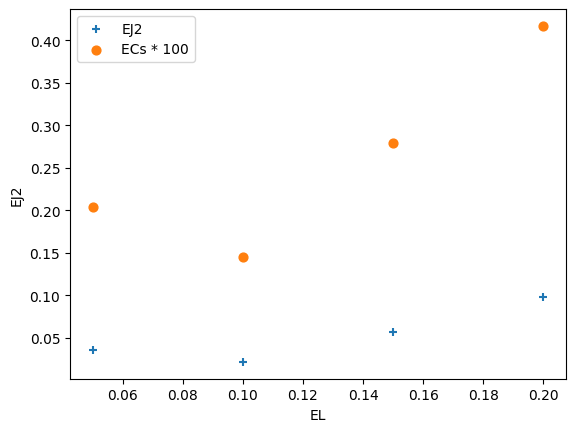

In [49]:
EJ = params['E_J']
EC = params['E_CJ']
EL_sweep = np.linspace(.05, .2, 4)
ECs_sweep = np.zeros_like(EL_sweep)

EJ2 = np.zeros_like(EL_sweep)
EJ4 = np.zeros_like(EL_sweep) 
EJ6 = np.zeros_like(EL_sweep)

for idx_EL, value_EL in enumerate(EL_sweep):
    EJ2[idx_EL], EJ4[idx_EL], EJ6[idx_EL] = getEJ2(EJ, EC, value_EL, Nmax=100, phiext_vec=None, ifplot=False)
    _ECs_vec = np.linspace(EJ2[idx_EL]/80, EJ2[idx_EL]/10, 1001)
    f01_th_vec = 16*_ECs_vec*np.sqrt(2/np.pi)*(2*EJ2[idx_EL]/_ECs_vec)**(3/4)*np.exp(-np.sqrt(2*EJ2[idx_EL]/_ECs_vec))
    kk = np.argmin(np.abs(f01_th_vec-1e-3))
    ECs_sweep[idx_EL] = _ECs_vec[kk]
    
fig = plt.figure()

plt.scatter(EL_sweep, EJ2, marker='+', s=40, label='EJ2')
plt.scatter(EL_sweep, ECs_sweep*100, marker='o', s=40, label='ECs * 100')
plt.xlabel('EL')
plt.ylabel('EJ2')
plt.legend()
plt.show()


In [50]:

levels = np.zeros((EL_sweep.size, params['num_osc']))
N_delta = np.zeros_like(EL_sweep)
Phi_delta = np.zeros_like(EL_sweep)

for idx_EL, value_EL in enumerate(EL_sweep):
    print('Progress: %5.1f%%'
            % (100. * (idx_EL + 1) / (len(EL_sweep))),end='\r')
    
    params['E_L'] = value_EL
    
    params['E_C'] = ECs_sweep[idx_EL]  
    qubit = Kite_Transmon_Full(params)

    levels[idx_EL] = qubit.levels()
    N_delta[idx_EL] = np.abs(qubit.n_delta_ij(0,1))
    Phi_delta[idx_EL] = np.abs(qubit.phi_delta_ij(0,1))



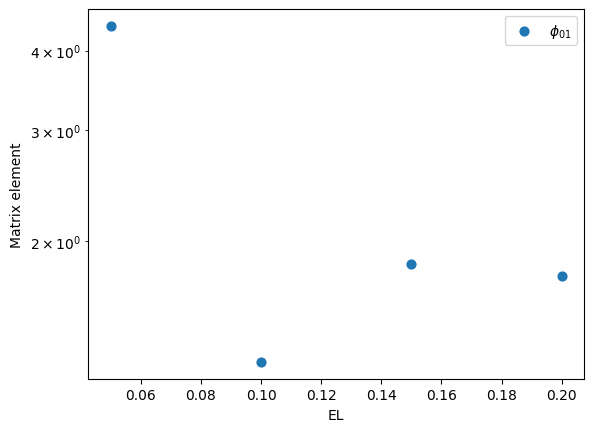

In [54]:
fig = plt.figure()
omega_01 = levels[:,1] - levels[:,0]

# plt.scatter(EL_sweep, N_delta**2, marker='+', s=40, label='$N_{01}$')
plt.scatter(EL_sweep, Phi_delta**2, marker='o', s=40, label='$\phi_{01}$')
# plt.plot(EL_sweep,( Phi_delta*omega_01/(4*params['E_CJ']))**2, linestyle='-', label='$N_{01}$ identity')
plt.xlabel('EL')
plt.ylabel('Matrix element')
plt.yscale('log')
plt.legend()
plt.show()

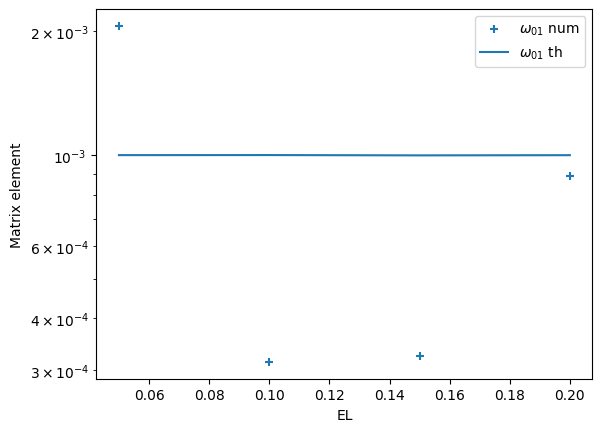

In [52]:
fig = plt.figure()
omega_01 = levels[:,1] - levels[:,0]

plt.scatter(EL_sweep, omega_01, marker='+', s=40, label='$\omega_{01}$ num')
plt.plot(EL_sweep, 16*ECs_sweep*np.sqrt(2/np.pi)*(2*EJ2/ECs_sweep)**(3/4)*np.exp(-np.sqrt(2*EJ2/ECs_sweep)), linestyle='-', label='$\omega_{01}$ th')
plt.xlabel('EL')
plt.ylabel('Matrix element')
plt.yscale('log')
plt.legend()
plt.show()